In [1]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy.special import kn,zetac
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
f = open('gFunctions.pcl','rb')
gSTAR = pickle.load(f)
gSTARS = pickle.load(f)
Tfunc = pickle.load(f)
f.close()

In [3]:
def nEQf(T,dof,mass):
    """Returns the equilibrium number density at temperature T. Returns zero for non-thermal components"""

    Zeta3 = zetac(3.) + 1.

    x = T/mass
    if x < 0.1:
        neq = mass**3*(x/(2*np.pi))**(3./2.)*np.exp(-1/x)*(1. + (15./8.)*x + (105./128.)*x**2) #Non-relativistic
    elif x < 1.5:            
        neq = mass**3*x*kn(2,1/x)/(2*np.pi**2) #Non-relativistic/relativistic
    else:
        if dof > 0: neq = Zeta3*T**3/np.pi**2   #Relativistic Bosons
        if dof < 0: neq = (3./4.)*Zeta3*T**3/np.pi**2   #Relativistic Fermions

    neq = neq*abs(dof)
    return neq

nEQ = np.vectorize(nEQf)

In [4]:
skiplines = 8
# d = np.genfromtxt('testSimple_1.5e-7.dat',names=True,skip_header=skiplines)
d = np.genfromtxt('testSimple.dat',names=True,skip_header=skiplines)

In [5]:
print(d.dtype.names)

('x', 'T', 'R', 'S', 'n_DM', 'rho_DM')


In [6]:
newtype = np.dtype(d.dtype.descr + [('s','<f8'),('neq_DM', '<f8')])
newdata = np.zeros(d.shape, dtype=newtype)
for name in d.dtype.names:
    newdata[name] = d[name]
newdata['s'] = d['S']/d['R']**3
newdata['neq_DM'] = nEQ(d['T'],-2,500.)
d = newdata

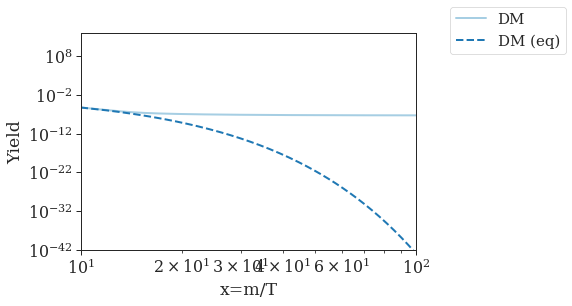

In [7]:
plt.plot(500./d['T'],d['n_DM']/d['s'],label='DM',linewidth=2)
plt.plot(500./d['T'],d['neq_DM']/d['s'],'--',label='DM (eq)',linewidth=2)
plt.xscale('log')
plt.yscale('log')
lgd = plt.legend(loc=(1.1,0.9),fontsize=15)
plt.ylim(1e-42,1e14)
plt.xlim(1e1,1e2)
plt.xlabel('x=m/T')
plt.ylabel('Yield')
# plt.savefig("Yield_noConversion.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [11]:
500./50.

10.0

In [9]:
from scipy.interpolate import interp1d

def nEQbottom(T):
    Zeta3 = 1.20206
    return 3*2*(3./4.)*Zeta3*T**3/np.pi**2

def nEQgluon(T):
    Zeta3 = 1.20206
    return 8*2*Zeta3*T**3/np.pi**2

#Annihilation rate for mediator
data = np.genfromtxt('./width_and_medxs.dat',skip_header=5)
conv = 0.8579e17

sLog = lambda x: interp1d(data[:,0],np.log(data[:,1]*conv),
                    fill_value='extrapolate',bounds_error=False)(x)

#Conversion rates for DM and mediator: 
dofDM = -2 #Number of DM degrees of freedom (Majorana fermion)

@np.vectorize
def sigmaVJan(T):
    x = 500./T
    if x > data[:,0].max():
        return 0.
    sF = sLog(x)
    return np.exp(sF)

In [10]:
T=5.
MP = 1.22*10**19
H = np.sqrt(8.*np.pi**3*gSTAR(T)/90.)*T**2/MP
sigmaVJan(T)*nEQ(T,-2,500.)/H

1.315050565673364e-31